In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(
    r"C:\Users\Mada Samhitha\sms_spam_detection\data\raw\SMSSpamCollection",
    sep = "\t",
    header = None,
    names = ["label","text"]
)

In [3]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.shape

(5572, 2)

In [5]:
df["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [6]:
df.isnull().sum()

label    0
text     0
dtype: int64

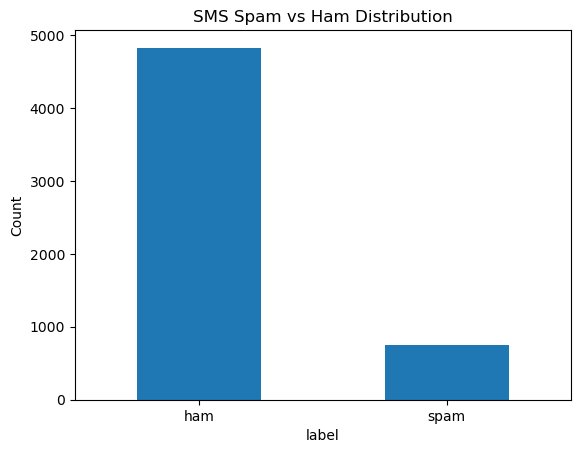

In [8]:
#class distribution plot 
import matplotlib.pyplot as plt
df["label"].value_counts().plot(
    kind="bar",
    title="SMS Spam vs Ham Distribution",
    rot=0
)

plt.ylabel("Count")
plt.show()

In [9]:
df["text_length"] = df["text"].str.len()

df["text_length"].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: text_length, dtype: float64

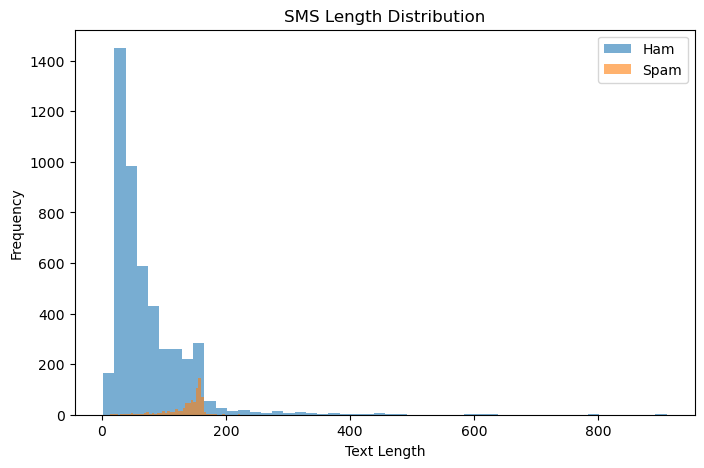

In [10]:
#Length distribution
plt.figure(figsize=(8,5))

plt.hist(
    df[df["label"]=="ham"]["text_length"],
    bins=50,
    alpha=0.6,
    label="Ham"
)

plt.hist(
    df[df["label"]=="spam"]["text_length"],
    bins=50,
    alpha=0.6,
    label="Spam"
)

plt.legend()
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("SMS Length Distribution")
plt.show()

### Exploratory Data Analysis

In [11]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

df.head()

,label,text,text_length,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in a wkly comp to win fa cup final ...
3,ham,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah i don t think he goes to usf he lives arou...


In [12]:
df["label_num"] = df["label"].map({"ham": 0, "spam": 1})

df[["label", "label_num"]].head()

,label,label_num
0,ham,0
1,ham,0
2,spam,1
3,ham,0
4,ham,0


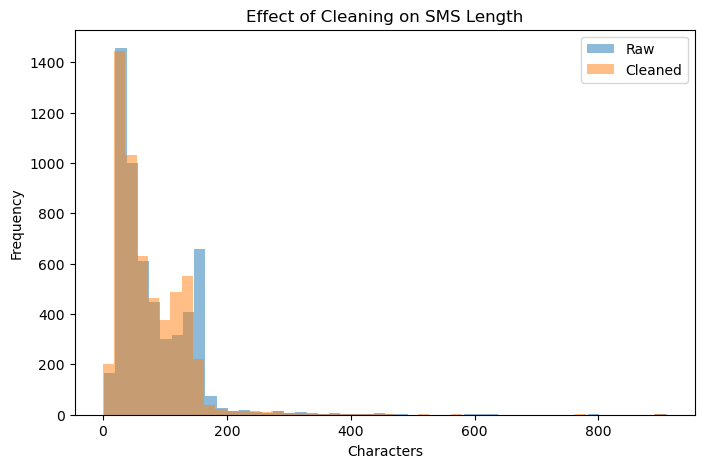

In [13]:
df["clean_length"] = df["clean_text"].str.len()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df["text_length"], bins=50, alpha=0.5, label="Raw")
plt.hist(df["clean_length"], bins=50, alpha=0.5, label="Cleaned")
plt.legend()
plt.title("Effect of Cleaning on SMS Length")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

### Text Preprocessing

Minimal text preprocessing was applied to preserve semantic information.
URLs and special characters were removed, while case normalization was performed
to reduce vocabulary size. Aggressive cleaning techniques were avoided to retain
important spam-indicative terms.

In [14]:
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["label_num"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(label_num
 0    0.865829
 1    0.134171
 Name: proportion, dtype: float64,
 label_num
 0    0.866368
 1    0.133632
 Name: proportion, dtype: float64)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1,2),
    min_df=3
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape

(4457, 3000)

In [16]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

lr_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


##### from sklearn.metrics import classification_report, confusion_matrix

y_pred = lr_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

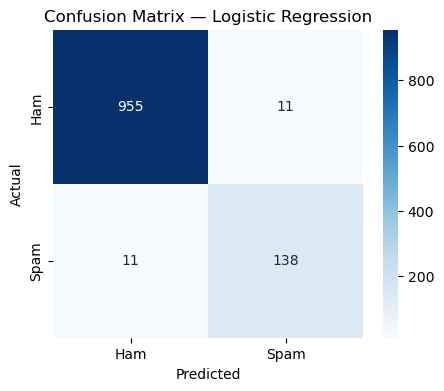

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Ham", "Spam"],
    yticklabels=["Ham", "Spam"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

### Baseline Model

A Logistic Regression classifier was trained using TF-IDF features.
Due to the short and informal nature of SMS messages, this combination
provides strong generalization and stable deployment behavior.

In [19]:
y_probs = lr_model.predict_proba(X_test_tfidf)[:, 1]

import pandas as pd
pd.Series(y_probs).describe()

count    1115.000000
mean        0.209677
std         0.276319
min         0.007399
25%         0.058923
50%         0.096662
75%         0.177792
max         0.992934
dtype: float64

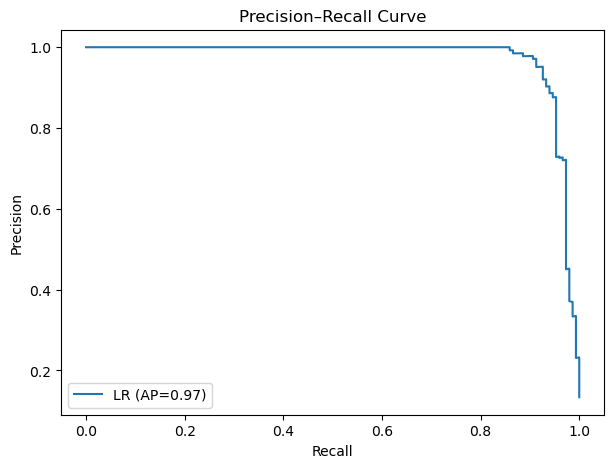

In [20]:
#precision-Recall Curve 
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
ap = average_precision_score(y_test, y_probs)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"LR (AP={ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()

In [30]:
custom_threshold = 0.4
y_pred_custom = (y_probs >= custom_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_custom))

confusion_matrix(y_test, y_pred_custom)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       966
           1       0.88      0.95      0.91       149

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115



array([[947,  19],
       [  8, 141]])

In [22]:
#Feature Interpretation 
import numpy as np

feature_names = tfidf.get_feature_names_out()
coefficients = lr_model.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

coef_df["abs_coefficient"] = coef_df["coefficient"].abs()
coef_df.sort_values("abs_coefficient", ascending=False).head()

,feature,coefficient,abs_coefficient
2555,txt,5.127800,5.127800
324,call,4.967998,4.967998
790,free,3.830537,3.830537
2293,text,3.794736,3.794736
1990,reply,3.542954,3.542954


In [23]:
coef_df.sort_values("coefficient", ascending=False).head(15)

,feature,coefficient,abs_coefficient
2555,txt,5.127800,5.127800
324,call,4.967998,4.967998
790,free,3.830537,3.830537
2293,text,3.794736,3.794736
1990,reply,3.542954,3.542954
2435,to,3.474491,3.474491
2568,uk,3.131855,3.131855
2218,stop,3.065052,3.065052
1532,mobile,2.974100,2.974100
427,claim,2.840245,2.840245


In [24]:
coef_df.sort_values("coefficient").head(15)

,feature,coefficient,abs_coefficient
1586,my,-2.424003,2.424003
1468,me,-2.065275,2.065275
1742,ok,-1.705859,1.705859
2309,that,-1.644009,1.644009
936,gt,-1.631887,1.631887
1423,lt,-1.609384,1.609384
1370,ll,-1.555087,1.555087
293,but,-1.524509,1.524509
1059,home,-1.433354,1.433354
1425,lt gt,-1.407064,1.407064


### Feature Interpretation

Feature analysis shows that spam predictions are driven by promotional and
action-oriented terms such as prize, free, claim, and win, while ham messages
are associated with conversational and contextual words. This improves the
interpretability and trustworthiness of the model.

In [34]:
from sklearn.pipeline import Pipeline
import joblib
import os

final_pipeline = Pipeline([
    ("tfidf", tfidf),
    ("classifier", lr_model)
])

os.makedirs("C:/Users/Mada Samhitha/sms_spam_detection/models", exist_ok=True)
joblib.dump(final_pipeline, "../models/sms_spam_lr_pipeline.pkl")

['../models/sms_spam_lr_pipeline.pkl']

In [36]:
loaded_model = joblib.load("../models/sms_spam_lr_pipeline.pkl")

test_msgs = [
    "Congratulations! You have won a free prize",
    "Are we meeting today at 6?"
]

cleaned = [clean_text(m) for m in test_msgs]
loaded_model.predict(cleaned)

array([1, 0])